## Clustering for Pairs Trading
A pairs trading strategy constructs a portfolio of correlated assets with similar market risk factor exposure. Temporary price discrepancies in these assets can create opportunities to profit through a long position in one instrument and a short position in another. A pairs trading strategy is designed to eliminate market risk and exploit these temporary discrepancies in the relative returns of stocks.

The fundamental premise in pairs trading is that **mean reversion** is an expected dynamic of the assets. This mean reversion should lead to a long-run equilibrium relationship, which we try to approximate through statistical methods. When moments of (presumably temporary) divergence from this long-term trend arise, one can possibly profit. The key to successful pairs trading is the ability to select the right pairs of assets to be used.

Our goal in this case study is to perform clustering analysis on the stocks in the S&P 500 to come up with pairs for a pairs trading strategy.

In [1]:
import pandas as pd
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv('./data/SP500Data.csv', index_col=0)

### Data Preparation
#### Data cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [2]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [3]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

# Getting rid of the columns with more than 30% missing values.
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

# Given that there are null values drop the rown contianing the null values
dataset.drop(labels=drop_list, axis=1, inplace=True)

In [4]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


#### Data Transformation
For the purpose of clustering, we will be using annual returns and variance as the variables as they are the indicators of the stock performance and its volatility. Let us prepare the return and volatility variables from the data.

In [5]:
import numpy as np
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = dataset.pct_change().mean() * 252
volatility = dataset.pct_change().std() * np.sqrt(252)

data = pd.DataFrame(data=returns, columns=['Returns'])
data['Volatility'] = volatility

All the variables should be on the same scale before applying clustering, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
X=rescaledDataset

### Evaluate Algorithms and Models

We will look at the following models:

- KMeans
- Hierarchical Clustering (Agglomerative Clustering)
- Affinity Propagation

### K-means Clustering
#### Finding optimal number of clusters
K-means initially assigns data points to clusters randomly and then calculates centroids or mean values. Fur‐ ther, it calculates the distances within each cluster, squares these, and sums them to get the sum of squared errors.
The basic idea is to define k clusters so that the total within-cluster variation (or error) is minimized. The following two methods are useful in finding the number of clusters in k-means:

- Sum of square errors (SSE)
- Silhouette score.

The **SSE** for each point is the square of the distance of the point from its predicted cluster center. The first cluster will add much information (explain a lot of variance), but eventually **the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point**; hence it is referred to as the “elbow criterion.

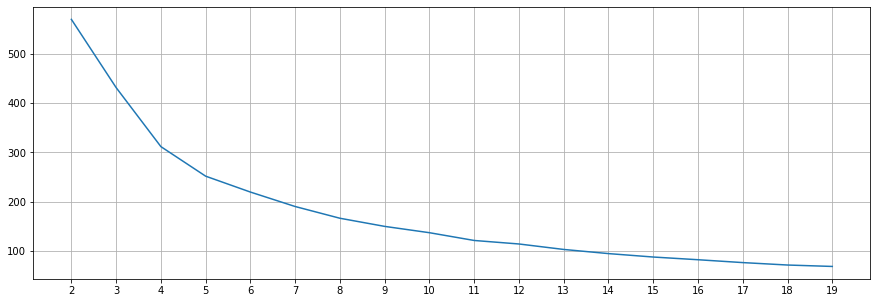

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    # Can give error if threadpoolctl version < 3.0
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)])
plt.grid(True)

Inspecting the sum of squared errors chart, it appears the elbow “kink” occurs 5 or 6 clusters for this data. Certainly, we can see that as the number of clusters increase pass 6, the sum of square of errors within clusters plateaus off.

#### Silhouette score
The silhouette score measures how similar a point is to its own cluster compared to other clusters. The range of the silhouette value is between 1 and –1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative silhouette value, that may indicate that we have created too many or too few clusters.

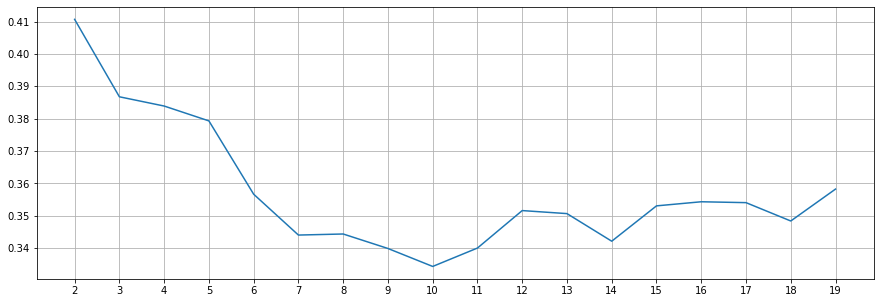

In [12]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)])
plt.grid(True)

From the silhouette score chart, we can see that there are various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 6 clusters, we would prefer 6 clusters in the K-means model.

#### Clustering and Visualisation
Let us build the k-means model with six clusters and visualize the results.

In [15]:
nclust=6
#Fit with k-means
k_means = KMeans(n_clusters=nclust)
k_means.fit(X)

#Extracting labels 
target_labels = k_means.predict(X)

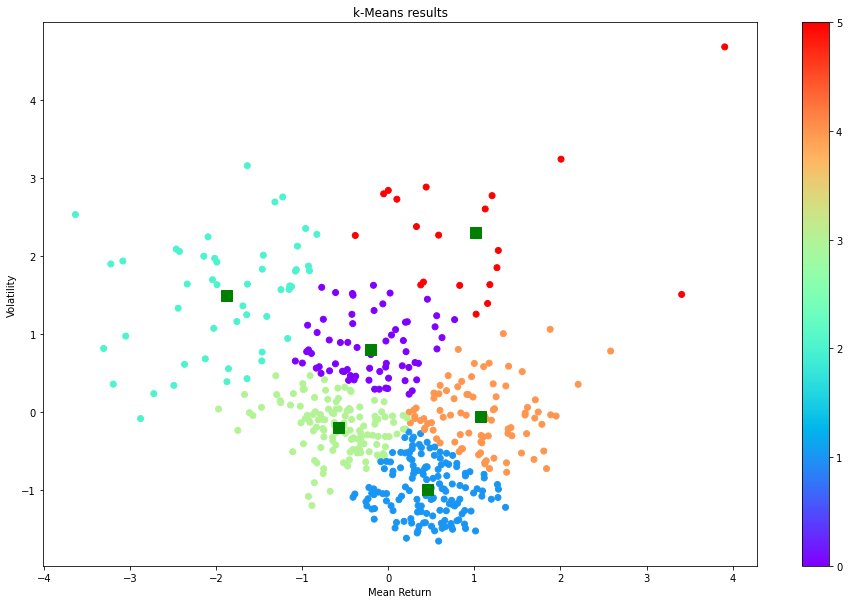

In [16]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

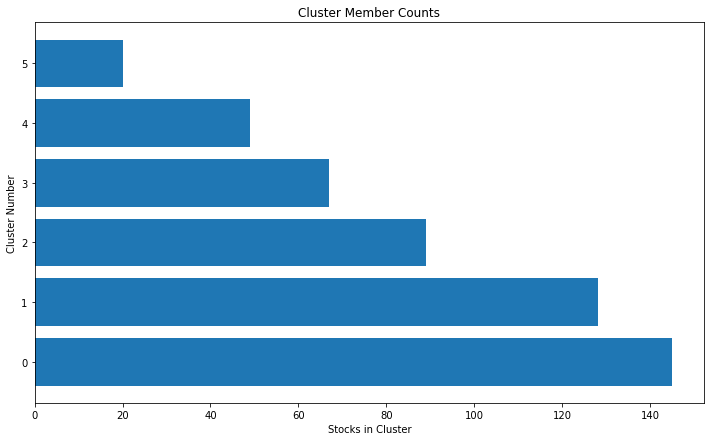

In [17]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

The number of stocks in a cluster range from around 40 to 120. Although, the distribution is not equal, we have significant number of stocks in each cluster.

### Hierarchical Clustering (Agglomerative Clustering)
In the first step we look at the hierarchy graph and check for the number of clusters.

#### Building Hierarchy Graph/ Dendogram
The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

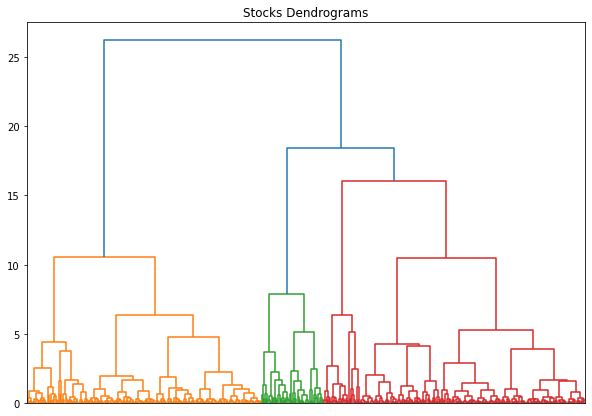

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage

#Calulate linkage
Z = linkage(X, method='ward')

#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
# remove stocks names on the x axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

Once one big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters. Then we select the distance threshold to cut the dendrogram to obtain the selected clustering level. The output is the cluster labelled for each row of data. As expected from the dendrogram, a cut at 13 gives us four clusters.

In [21]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 13
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([1, 4, 3, 2], dtype=int32)

#### Clustering and Visualisation

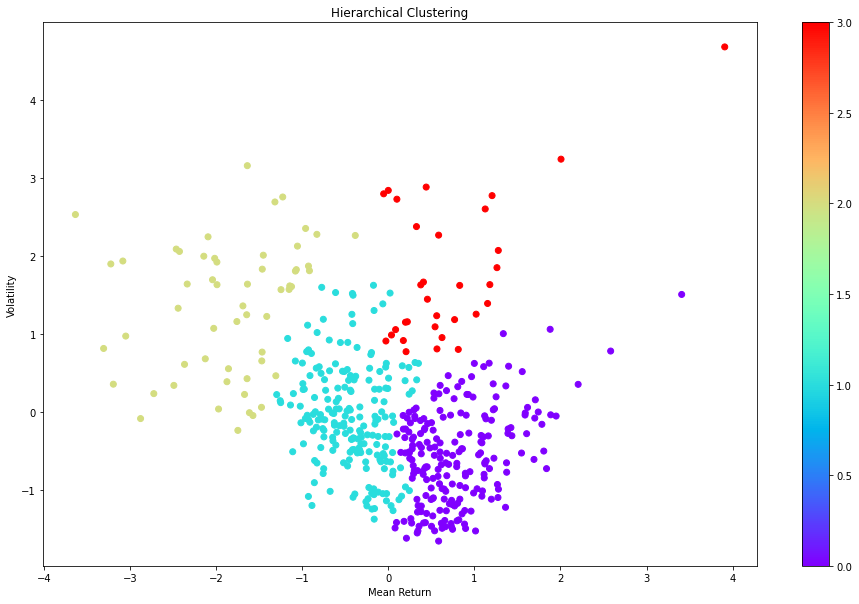

In [23]:
from sklearn.cluster import AgglomerativeClustering
# Fit
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

# Plot
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

Similar to the plot of k-means clustering, we see that there are some distinct clusters separated by different colors.

### Affinity Propagation

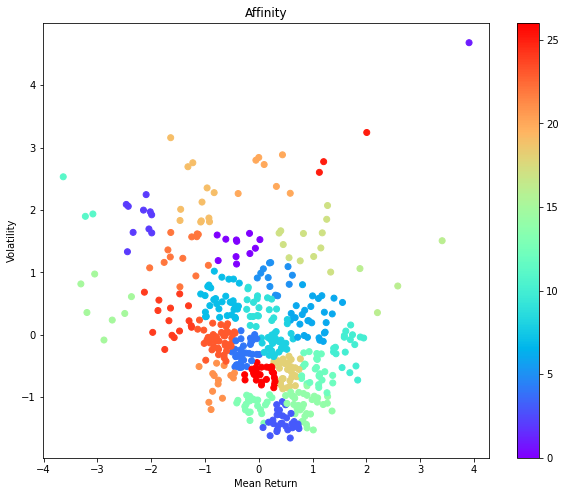

In [25]:
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

Estimated number of clusters: 27


<Figure size 432x288 with 0 Axes>

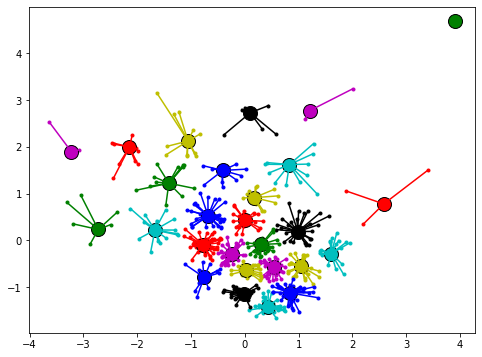

In [27]:
from itertools import cycle
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_
no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

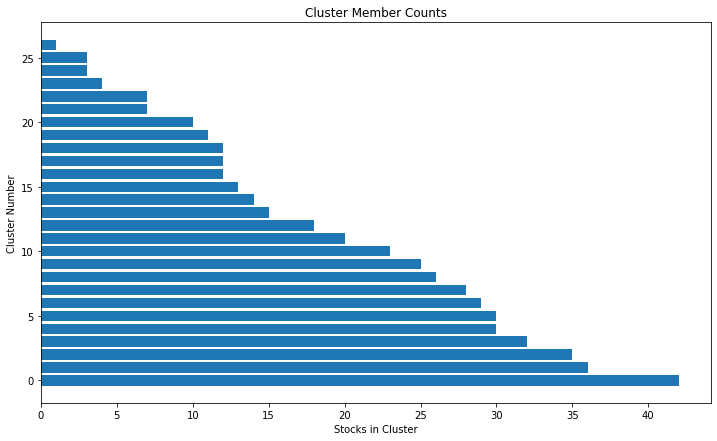

In [28]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### Cluster evaluation
If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters.

In [29]:
from sklearn.metrics import silhouette_score
print("km", silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.35492201187133127
hc 0.34321495156408643
ap 0.3450647315156527


Given the k-means performs the best, we go ahead with the k-means and use 6 clusters as specified by this clustering method.
#### Visualising the return within a cluster
The understand the intuition behind clustering, let us visualize the results of the clusters.

In [30]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [31]:
# get the number of stocks in each cluster
counts = clustered_series_ap.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[25, 11, 16, 20, 15, 2, 0, 19, 17, 5, 22, 21, 24, 10, 9, 13]

In [32]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 6
Pairs to evaluate: 55070


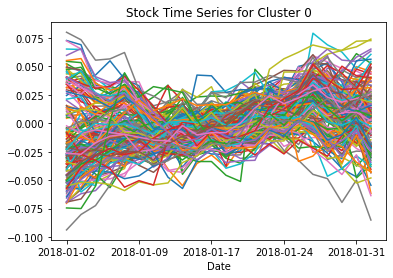

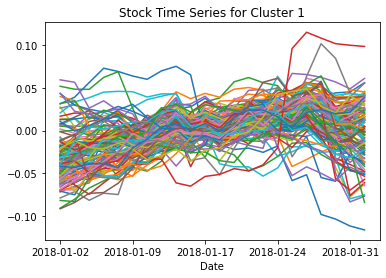

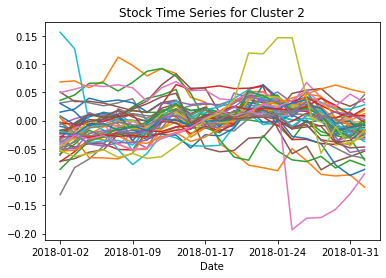

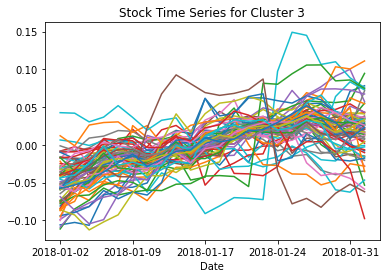

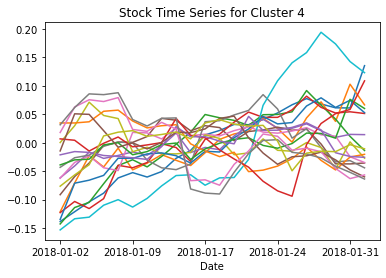

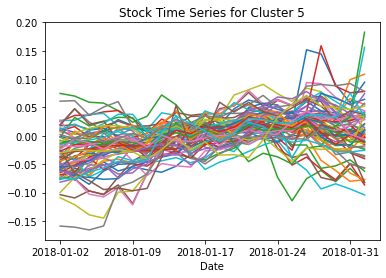

In [35]:
for clust in range(0, 6):
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:"2018-02-01", tickers].mean())
    data = np.log(dataset.loc[:"2018-02-01", tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust, )
plt.show()


Looking at the charts above we see similar movement of the stocks under different clusters, which corroborates the effectiveness of the clustering technique.

## Pairs Selection
Once the clusters are created, several cointegration-based statistical techniques can be applied on the stocks within a cluster to create the pairs. Two or more time series are considered to be **cointegrated** if they are nonstationary and tend to move together. The presence of cointegration between time series can be validated through several statistical techniques, including the Augmented Dickey-Fuller test and the Johansen test.

In this step, we scan through a list of securities within a cluster and test for cointegration between the pairs. First, we write a function that returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05.

In [37]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

Next, we check the cointegration of different pairs within several clusters using the function created above and return the pairs found:

In [38]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [39]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [40]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 41
In those pairs, there are 46 unique tickers.


In [45]:
pairs

[('ABT', 'AEE'),
 ('ABT', 'AEP'),
 ('ABT', 'AWK'),
 ('ABT', 'AON'),
 ('ABT', 'AIV'),
 ('ABT', 'AJG'),
 ('ABT', 'ATO'),
 ('ABT', 'AVB'),
 ('ABT', 'CMS'),
 ('ABT', 'ED'),
 ('ABT', 'COO'),
 ('ABT', 'DTE'),
 ('ABT', 'FRT'),
 ('ABT', 'HCP'),
 ('ABT', 'HOLX'),
 ('ABT', 'KMB'),
 ('ABT', 'MCD'),
 ('ABT', 'NI'),
 ('ABT', 'PNW'),
 ('ABT', 'PG'),
 ('ABT', 'PEG'),
 ('ABT', 'REG'),
 ('ABT', 'RSG'),
 ('ABT', 'TMUS'),
 ('ABT', 'UDR'),
 ('ABT', 'VTR'),
 ('ABT', 'WELL'),
 ('ABT', 'XEL'),
 ('A', 'WAT'),
 ('ADBE', 'ADI'),
 ('ADBE', 'AZO'),
 ('ADBE', 'CDNS'),
 ('ADBE', 'CMG'),
 ('ADBE', 'ROST'),
 ('ADBE', 'TSCO'),
 ('ADBE', 'VFC'),
 ('ABBV', 'BWA'),
 ('AMG', 'AAL'),
 ('AMG', 'DD'),
 ('AMG', 'FCX'),
 ('AMG', 'NLSN')]

### Pair visualization
Let us visualize the results of the pair selection process now using the t-SNE technique. 

In [41]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [42]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [43]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

The following chart shows the strength of k-means for finding nontraditional pairs, for example look at the 2 brown points. ABBVA is the ticker symbol for AbbVie (biopharma), and BWA is the ticker symbol for BorgWarner (automotive). These two stocks are from different sectors and appear to have nothing in common on the surface, but they are identified as pairs using k-means clustering and cointegration testing. This implies that a long-run stable relationship exists between their stock price movements.

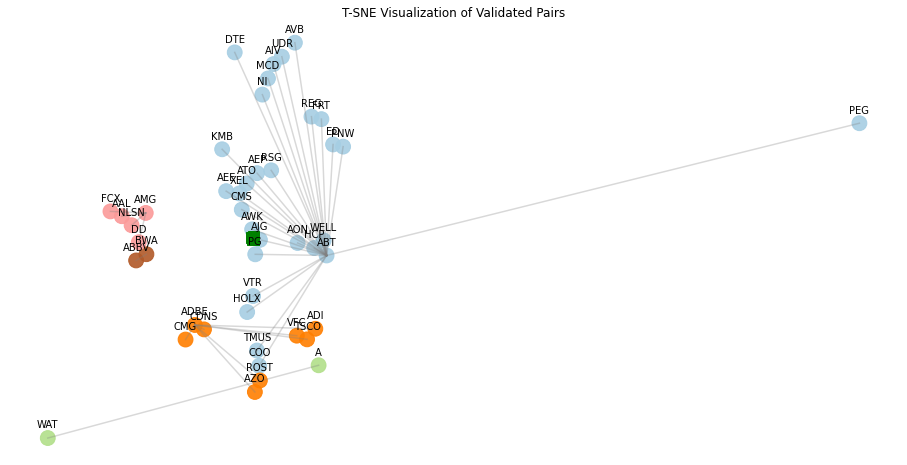

In [44]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs'); 

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

Once the pairs are created, they can be used in a pairs trading strategy. When the share prices of the pair deviate from the identified long-run relationship, an investor would seek to take a long position in the underperforming security and sell short the outperforming security. If the securities return to their historical relationship, a profit is made from the convergence of the prices.